In [1]:
from utils import create_lamp_grid, calculate_areas, original_calculate_areas, plot_lamps
import random
import numpy as np
import copy
import matplotlib.pyplot as plt
import imageio

## Group Evolution

In [2]:
# The individual generator
def GE_i_generator(random, args):
    return (random.uniform(0, 1), random.uniform(0, 1))

In [3]:
# The group generator
def GE_g_generator(nprandom, args):
    num_individuals = args.get('num_individuals')
    bound = args.get('bound_groups')
    num_groups = args.get('num_groups')
    
    Times = [1] * num_individuals
    cs = list(range(num_individuals))
    groups = []
    groups_set = set()
    
    i = 0
    while i < num_groups:
        num_lamps = nprandom.randint(bound[0], bound[1])
        Weights = [1 / (Times[lamp] ** 2) for lamp in cs]
        probabilities = [weight / sum(Weights) for weight in Weights]
        chosen_lamps = nprandom.choice(cs, size=num_lamps, replace=False, p=probabilities)
        chosen_lamps.sort()
        chosen_lamps = tuple(chosen_lamps)
        if chosen_lamps not in groups_set:
            groups.append([None, chosen_lamps])
            groups_set.add(chosen_lamps)
            for lamp in chosen_lamps:
                Times[lamp] += 1
            i += 1
    return groups

In [4]:
# The group evaluator
def GE_evaluator(groups, lamp_grid, index_to_cs, fitness_individuals, args):
    grid_size = args.get('grid_size')
    problem_size = args.get('problem_size')
    weight_overlap = args.get('weight_overlap')
    
    for group in groups:
        if group[0] is None:
            lamps = [index_to_cs[lamp] for lamp in group[1]]
            enlightened_area, overlap_area = calculate_areas(lamps, grid_size, problem_size, lamp_grid)
            group[0] = enlightened_area - weight_overlap * overlap_area
            for lamp in group[1]:
                if lamp not in fitness_individuals:
                    fitness_individuals[lamp] = group[0]
                else:
                    fitness_individuals[lamp] = max(fitness_individuals[lamp], group[0])
    return groups, fitness_individuals

In [5]:
def slaughter_groups(groups, args):
    num_groups = args.get('num_groups')
    # Slaughtering of groups
    # groups.sort(key=lambda x: x[0], reverse=True)
    groups = groups[:num_groups]
    return groups

def slaughter_individuals(groups, index_to_cs, args):
    # Slaughtering of individuals
    new_index_to_cs = {}
    for group in groups:
        for cs in group[1]:
            if cs not in new_index_to_cs:
                new_index_to_cs[cs] = index_to_cs[cs]
    return new_index_to_cs

In [6]:
def GE_g_operator(random, parents, groups_set, index_to_cs, args):
    mutation_rate = args.get('mutation_rate')
    crossover_rate = args.get('crossover_rate')
    bound_groups = args.get('bound_groups')
    
    # Crossover
    random.shuffle(parents)
    
    if len(parents) % 2 == 1:
        parents = parents[:-1]
    moms = parents[::2]
    dads = parents[1::2]
    children = []
    
    for (mom, dad) in zip(moms, dads):
        if random.random() < crossover_rate:
            group1, group2 = list(mom[1]), list(dad[1])
            index1 = random.randint(0, len(group1)-1)
            index2 = random.randint(0, len(group2)-1)
            group1[index1], group2[index2] = group2[index2], group1[index1]
            group1.sort(), group2.sort()
            c1, c2 = tuple(group1), tuple(group2)
            if c1 not in groups_set:
                children.append([None, c1])
                groups_set.add(c1)
            if c2 not in groups_set:
                children.append([None, c2])
                groups_set.add(c2)
    
    # Adding-mutation
    set_cs = set(index_to_cs.keys())
    for group in children:
        if len(group[1]) < bound_groups[1] and random.random() < mutation_rate:
            tmp_list = list(set_cs - set(group[1]))
            if len(tmp_list) != 0:
                lamp_added = tmp_list[random.randint(0, len(tmp_list)-1)]
                new_group = list(group[1])
                new_group.append(lamp_added)
                new_group.sort()
                new_group = tuple(new_group)
                if new_group not in groups_set:
                    children.append([None, new_group])
                    groups_set.add(new_group)
    
    # Removing-mutation
    for group in children:
        if len(group[1]) > bound_groups[0] and random.random() < mutation_rate:
            lamp_removed = random.choice(group[1])
            new_group = list(group[1])
            new_group.remove(lamp_removed)
            new_group = tuple(new_group)
            if new_group not in groups_set:
                children.append([None, new_group])
                groups_set.add(new_group)
    
    # Replacement-mutation
    for group in children:
        if random.random() < mutation_rate:
            lamp_removed = random.choice(group[1])
            tmp_list = list(set_cs - set(group[1]))
            if len(tmp_list) != 0:
                lamp_added = tmp_list[random.randint(0, len(tmp_list)-1)]
                new_group = list(group[1])
                new_group.remove(lamp_removed)
                new_group.append(lamp_added)
                new_group.sort()
                new_group = tuple(new_group)
                if new_group not in groups_set:
                    children.append([None, new_group])
                    groups_set.add(new_group)

    return children, groups_set

In [7]:
def GE_i_operator(random, parents, groups, index_to_cs, args):
    mutation_rate = args.get('mutation_rate')
    crossover_rate = args.get('crossover_rate')
    bound_groups = args.get('bound_groups')
    bound_lamps = args.get('bound_lamps')
    upper_bound, lower_bound = bound_lamps[1], bound_lamps[0]
    
    lamps_set = set(index_to_cs.values())
    
    individuals_groups = {value : set() for value in index_to_cs.values()}
    for group in groups:
        for i in group[1]:
            cs = index_to_cs[i]
            individuals_groups[cs].add(group[1])
    next_index = max(index_to_cs.keys()) + 1
    children = []
    
    # Crossover
    random.shuffle(parents)
    
    if len(parents) % 2 == 1:
        parents = parents[:-1]
    moms = parents[::2]
    dads = parents[1::2]
    children = []
    
    for (mom, dad) in zip(moms, dads):
        mom_lamp = index_to_cs[mom]
        dad_lamp = index_to_cs[dad]
        
        if random.random() < crossover_rate:
            new_lamp1 = (mom_lamp[0], dad_lamp[1])
            new_lamp2 = (dad_lamp[0], mom_lamp[1])
            
            for i, new_lamp in enumerate([new_lamp1, new_lamp2]):
                if new_lamp in lamps_set:
                    continue
                
                lamps_set.add(new_lamp)
                index_to_cs[next_index] = new_lamp
                next_index += 1
                
                if random.random() < 0.5:
                    parent = mom
                else:
                    parent = dad
                    
                for group in individuals_groups[index_to_cs[parent]]:
                    new_group = list(group)
                    new_group.remove(parent)
                    new_group.append(next_index - 1)
                    new_group = tuple(new_group)
                    children.append([None, new_group])
                    # The three lines below add new groups to existing groups immediately.
                    
                    # for index in new_group:
                    #     if index != next_index - 1:
                    #         individuals_groups[index_to_cs[index]].add(new_group)
    # Mutation
    for index_parent in parents:
        parent = index_to_cs[index_parent]
        if random.random() < mutation_rate:
            new_lamp = (parent[0] + random.uniform(0, 0.1), parent[1] + random.uniform(0, 0.1))
            new_lamp = (max(min(new_lamp[0], upper_bound), lower_bound), 
                        max(min(new_lamp[1], upper_bound), lower_bound))
            if new_lamp in lamps_set:
                continue
           
            lamps_set.add(new_lamp)  
            index_to_cs[next_index] = new_lamp
            next_index += 1
            
            for group in individuals_groups[parent]:
                new_group = list(group)
                new_group.remove(index_parent)
                new_group.append(next_index - 1)
                new_group = tuple(new_group)
                children.append([None, new_group])
                # The three lines below add new groups to existing groups immediately.
                
                # for index in new_group:
                #     if index != next_index - 1:
                #         individuals_groups[index_to_cs[index]].add(new_group)
    return children, index_to_cs

In [8]:
def GE_g_tournament_select(random, population, args):
    num_selected = args.get('num_selected') 
    tournament_size = args.get('group_tournament_size')
    
    if tournament_size > len(population):
        tournament_size = len(population)
    selected = []
    
    for _ in range(num_selected):
        tourn = random.sample(population, tournament_size)
        tourn.sort(key=lambda x: x[0], reverse=True)
        selected.append(tourn[0])
    return selected

In [9]:
def GE_i_tournament_select(random, group, fitness_individuals, args):
    tournament_size = args.get('individual_tournament_size')

    tourn = random.sample(group[1], tournament_size)
    tourn.sort(key=lambda x: fitness_individuals[x], reverse=True)
    
    return tourn[0]

In [10]:
def group_evolution(random, nprandom, args):
    # Generate the initial population
    grid_size = args['grid_size']
    problem_size = args['problem_size']
    max_generations = args['max_generations']
    num_individuals = args['num_individuals']
    
    index_to_cs = {}
    fitness_individuals = {}
    groups_set = set()
    lamp_grid = create_lamp_grid(grid_size, problem_size)
    individuals_records = []
    
    for i in range(num_individuals):
        cs = (GE_i_generator(random, args))
        index_to_cs[i] = cs
    
    # Generate the initial groups
    groups = GE_g_generator(nprandom, args)

    # Evaluation the groups
    groups, fitness_individuals = GE_evaluator(groups, lamp_grid, index_to_cs, fitness_individuals, args)
    groups.sort(key=lambda x: x[0], reverse=True)
    individuals_records.append([list(index_to_cs.values()), [index_to_cs[i] for i in groups[0][1]]])
    
    # Main loop
    for generation in range(max_generations):
        # Slaughtering of groups
        groups = slaughter_groups(groups, args)
        groups_set = set([group[1] for group in groups])
        
        # Slaughtering of orphaned individuals
        index_to_cs = slaughter_individuals(groups, index_to_cs, args)
        
        # Apply group genetic operators
        parents = GE_g_tournament_select(random, groups, args)
        offspring, groups_set = GE_g_operator(random, parents, groups_set, index_to_cs, args)
       
        # Evaluation the offspring
        offspring, fitness_individuals = GE_evaluator(offspring, lamp_grid, index_to_cs, fitness_individuals, args)
        groups += offspring
               
        # Apply individual genetic operators
        groups_parents = GE_g_tournament_select(random, groups, args)
        individuals_parents = set()
        for group in groups_parents:
            individuals_parents.add(GE_i_tournament_select(random, group, fitness_individuals, args))
        individuals_parents = list(individuals_parents)
        offspring, index_to_cs = GE_i_operator(random, individuals_parents, groups, index_to_cs, args)
        
        # Evaluation the offspring
        offspring, fitness_individuals = GE_evaluator(offspring, lamp_grid, index_to_cs, fitness_individuals, args)
        groups += offspring
        
        # Print the best solution for observation
        groups.sort(key=lambda x: x[0], reverse=True)
        
        # The observer
        print('Generation: {}. Best fitness: {}'.format(generation, groups[0][0]))
        individuals_records.append([list(index_to_cs.values()), [index_to_cs[i] for i in groups[0][1]]])
        
    # Slaughtering of groups
    groups = slaughter_groups(groups, args)
        
    return index_to_cs, groups, individuals_records

In [11]:
rand = random.Random()
rand.seed(39)
nprand = np.random.RandomState(39)
bound_lamps = (0, 1)
grid_size = 500
problem_size = 10
bound_groups = (problem_size, problem_size*3)
# It takes about 6 minutes to run.
index_to_cs, groups,individuals_records = group_evolution(rand, nprand, 
                                                          {'grid_size': grid_size, 
                                                           'problem_size': problem_size, 
                                                           'max_generations': 100, 
                                                           'num_individuals': problem_size*5, 
                                                           'num_groups': problem_size*20,
                                                           'mutation_rate': 0.8,
                                                           'crossover_rate': 1,
                                                           'bound_lamps': bound_lamps,
                                                           'bound_groups': bound_groups, 
                                                           'group_tournament_size': problem_size*4,
                                                           'individual_tournament_size': 2,
                                                           'num_selected': 5,
                                                           'weight_overlap': 1})

Generation: 0. Best fitness: 0.5134479999999999
Generation: 1. Best fitness: 0.523112
Generation: 2. Best fitness: 0.53596
Generation: 3. Best fitness: 0.5596559999999999
Generation: 4. Best fitness: 0.5596559999999999
Generation: 5. Best fitness: 0.569944
Generation: 6. Best fitness: 0.569944
Generation: 7. Best fitness: 0.584832
Generation: 8. Best fitness: 0.584832
Generation: 9. Best fitness: 0.584832
Generation: 10. Best fitness: 0.591296
Generation: 11. Best fitness: 0.6012
Generation: 12. Best fitness: 0.6012
Generation: 13. Best fitness: 0.6044080000000001
Generation: 14. Best fitness: 0.623008
Generation: 15. Best fitness: 0.6293599999999999
Generation: 16. Best fitness: 0.6295200000000001
Generation: 17. Best fitness: 0.637384
Generation: 18. Best fitness: 0.637384
Generation: 19. Best fitness: 0.637384
Generation: 20. Best fitness: 0.65276
Generation: 21. Best fitness: 0.6546559999999999
Generation: 22. Best fitness: 0.660264
Generation: 23. Best fitness: 0.6750480000000001


In [12]:
# Transform the indexes to coordinates
groups_xy = []
for group in groups:
    g_xy = [group[0], []]
    for i in group[1]:
        g_xy[1].append(index_to_cs[i])
    groups_xy.append(g_xy)
groups_xy

[[0.7530079999999999,
  [(0.5008721136884221, 0.13586122193007022),
   (0.1743091859216107, 0.219455462895102),
   (0.8143266835685603, 0.20046272094992995),
   (0.8143266835685603, 0.5298588074659512),
   (0.16283906455095554, 0.5298588074659512),
   (0.4830929036064152, 0.44717524800335556),
   (0.17729689904098667, 0.843547199342713),
   (0.5121380954992998, 0.9711514328215679),
   (0.5194803459848836, 0.7583926348174785),
   (0.8606080588747033, 0.843547199342713)]],
 [0.7527839999999999,
  [(0.8606080588747033, 0.8384920995686362),
   (0.5008721136884221, 0.13586122193007022),
   (0.1743091859216107, 0.219455462895102),
   (0.8143266835685603, 0.20046272094992995),
   (0.8143266835685603, 0.5298588074659512),
   (0.16283906455095554, 0.5298588074659512),
   (0.4830929036064152, 0.44717524800335556),
   (0.17729689904098667, 0.843547199342713),
   (0.5121380954992998, 0.9711514328215679),
   (0.5194803459848836, 0.7583926348174785)]],
 [0.7527440000000001,
  [(0.5008721136884221, 0

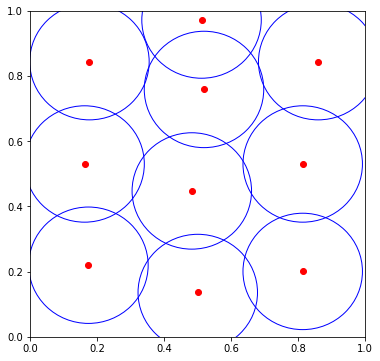

In [13]:
plot_lamps(groups_xy[0][1], problem_size)

In [14]:
lamp_grid = create_lamp_grid(grid_size, problem_size)
calculate_areas(groups_xy[0][1], grid_size, problem_size, lamp_grid)

(0.876504, 0.12349600000000005)

In [15]:
# Make a gif of the evolution process
# Record all the pictures
frames = []

for i, records in enumerate(individuals_records): 
    # Create a new figure
    fig = plt.figure(dpi=300)

    # print all the points in the picture by plt
    for value in records[0]:
        plt.scatter(value[0], value[1], color='blue')
    for p in records[1]:
        plt.scatter(p[0], p[1], color='red')
    
    # adjust the range of x and y axis
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    ae, ao = calculate_areas(records[1], grid_size, problem_size, lamp_grid)
    
    plt.title('Generation: {} Fitness: {:.4f}'.format(i, ae-ao))
    # adjust the radio of x and y axis
    plt.gca().set_aspect('equal', adjustable='box')

    # Save the current figure
    fig.canvas.draw()       
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    frames.append(image)
    
    plt.close(fig)

# Create a gif
imageio.mimsave('evolution_10.gif', frames, 'GIF', duration=0.2)